# Import bibliotek

In [1]:
import os
import shutil
import librosa
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import IPython.display as ipd
import tensorflow as tf
from PIL import Image

Do zbudowania naszego zbioru danych wykorzystamy trzy zbiory:
*  KAUH
*  ICBHI
*  Covid-19

In [2]:
# ścieżki do katalogów z danymi
RAW_DATA_PATH = "./Raw_datasets/"
KAUH_DATA_PATH = f"./{RAW_DATA_PATH}/KAUH_Lung_files"
ICBHI_DATA_PATH = f"./{RAW_DATA_PATH}/Respiratory_Sound_Database"
VIRUFY_DATA_PATH = f"./{RAW_DATA_PATH}/covid-19_dataset"

In [3]:
# Sprawdzanie poprawności ścieżek folderów
print("RAW DATA: ", os.path.exists(RAW_DATA_PATH))
print("KAUH: ", os.path.exists(KAUH_DATA_PATH))
print("ICBHI: ", os.path.exists(ICBHI_DATA_PATH))
print("VIRUFY: ", os.path.exists(VIRUFY_DATA_PATH))

RAW DATA:  True
KAUH:  True
ICBHI:  True
VIRUFY:  True


# Przetwarzanie zbioru ICBHI

### Wczytanie danych o chorobach pacjentów

In [4]:
patient_diseases_info = pd.read_csv(f'./{ICBHI_DATA_PATH}/patient_diagnosis.csv')
patient_diseases_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126 entries, 0 to 125
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   PatientID  126 non-null    int64 
 1   Diagnosis  126 non-null    object
dtypes: int64(1), object(1)
memory usage: 2.1+ KB


In [5]:
unique_diseases = patient_diseases_info['Diagnosis'].unique()
unique_diseases = sorted(unique_diseases)
print(f'Unikalne nazwy chorób płucnych: {unique_diseases}')

Unikalne nazwy chorób płucnych: ['Asthma', 'Bronchiectasis', 'Bronchiolitis', 'COPD', 'Healthy', 'LRTI', 'Pneumonia', 'URTI']


                Ilość pacjentów:
Diagnosis                       
COPD                          64
Healthy                       26
URTI                          14
Bronchiectasis                 7
Bronchiolitis                  6
Pneumonia                      6
LRTI                           2
Asthma                         1


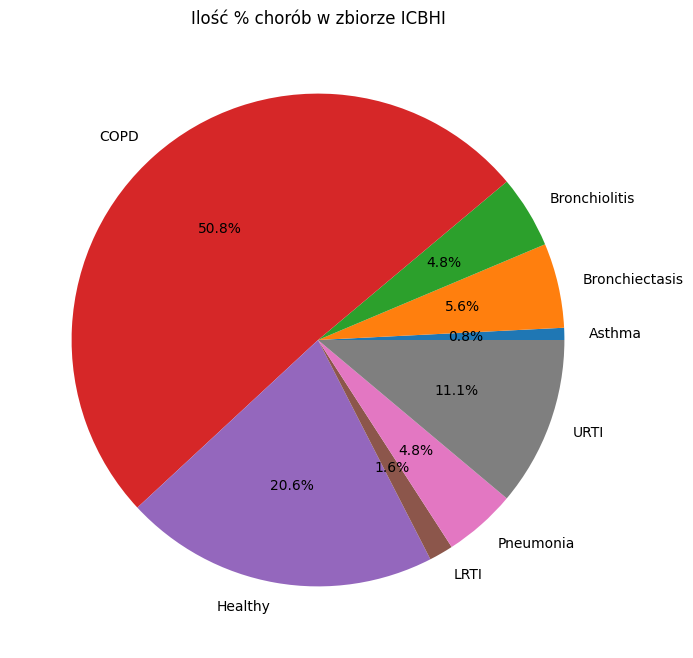

In [50]:
number_of_diseases = patient_diseases_info.groupby(['Diagnosis']).count()
print(number_of_diseases.sort_values(by=['PatientID'],ascending=False).rename(columns = {'PatientID':'Ilość pacjentów:'}))
plt.figure(figsize=(10,8))
plt.pie(number_of_diseases['PatientID'],labels=number_of_diseases.index,autopct='%1.1f%%')
plt.title("Ilość % chorób w zbiorze ICBHI")
plt.show()

### Segregacja plików audio ze względu na choroby 

In [7]:
#Tworzenie głównego folderu z danymi
if not os.path.exists('./data'):
    print("TWORZENIE KATALOGU GŁÓWNEGO")
    os.mkdir("./data")

#Tworzenie folderu dla audio
if not os.path.exists('./data/audio'):
    print("TWORZENIE KATALOGU DLA AUDIO")
    os.mkdir("./data/audio")

#Tworzenie podfolderów audio
for diseas in unique_diseases:
    if not os.path.exists(f"./data/audio/{diseas}"):
        print(f"TWORZENIE PODKATALOGU DLA AUDIO CHOROB : {diseas}")
        os.mkdir(f"./data/audio/{diseas}")


In [8]:
#Segregacja plików audio ze względu na choroby
for diseas in unique_diseases:
    print(f'CHOROBA {diseas}')

    #Szukanie po chorobie
    patient_list = patient_diseases_info[patient_diseases_info['Diagnosis'] == diseas]
    print(patient_list)
    
    for patient_id in patient_list['PatientID']:
        patient_files = glob.glob(f'{ICBHI_DATA_PATH}/audio_and_txt_files/{patient_id}*.wav')

        print(f'Pliki pacjenta: {patient_files}')

        for patient_file in patient_files:
            print("KOPIOWANIE: ",patient_file)
            shutil.copy(patient_file, f'./data/audio/{diseas}')

print("Pliki zostały posegregowane...")


CHOROBA Asthma
   PatientID Diagnosis
2        103    Asthma
Pliki pacjenta: ['././Raw_datasets//Respiratory_Sound_Database/audio_and_txt_files\\103_2b2_Ar_mc_LittC2SE.wav']
KOPIOWANIE:  ././Raw_datasets//Respiratory_Sound_Database/audio_and_txt_files\103_2b2_Ar_mc_LittC2SE.wav
CHOROBA Bronchiectasis
     PatientID       Diagnosis
10         111  Bronchiectasis
15         116  Bronchiectasis
67         168  Bronchiectasis
68         169  Bronchiectasis
95         196  Bronchiectasis
100        201  Bronchiectasis
114        215  Bronchiectasis
Pliki pacjenta: ['././Raw_datasets//Respiratory_Sound_Database/audio_and_txt_files\\111_1b2_Tc_sc_Meditron.wav', '././Raw_datasets//Respiratory_Sound_Database/audio_and_txt_files\\111_1b3_Tc_sc_Meditron.wav']
KOPIOWANIE:  ././Raw_datasets//Respiratory_Sound_Database/audio_and_txt_files\111_1b2_Tc_sc_Meditron.wav
KOPIOWANIE:  ././Raw_datasets//Respiratory_Sound_Database/audio_and_txt_files\111_1b3_Tc_sc_Meditron.wav
Pliki pacjenta: ['././Raw_datas

## Etapy tworzenia spektogramów dla pliku audio

In [9]:
#Tworzenie folderu dla spectogramów
if not os.path.exists('./data/spectograms'):
    print("TWORZENIE KATALOGU DLA SPEKTOGRAMÓW")
    os.mkdir("./data/spectograms")

#Tworzenie podfolderów spectogramów
for diseas in unique_diseases:
    if not os.path.exists(f"./data/spectograms/{diseas}"):
        print(f"TWORZENIE PODKATALOGU DLA SPEKTOGRAMÓW CHOROBY : {diseas}")
        os.mkdir(f"./data/spectograms/{diseas}")

In [10]:
audio_files = glob.glob('../lung_diseases_detection/data/audio/*/*.wav')
audio_files[1]

'../lung_diseases_detection/data/audio\\Bronchiectasis\\111_1b2_Tc_sc_Meditron.wav'

In [11]:
# Plik audio
ipd.Audio(audio_files[1])

In [13]:
# Wczytanie pliku
wave, sr = librosa.load(audio_files[1])

print(f'Wave: {wave[:10]}')
print(f'shape Wave: {wave.shape}')
print(f'SAMPLE RATE: {sr}')

Wave: [-0.00200442 -0.00318893 -0.00332277 -0.00359193 -0.00384032 -0.00405994
 -0.00402486 -0.00377632 -0.00332576 -0.00300147]
shape Wave: (441001,)
SAMPLE RATE: 22050


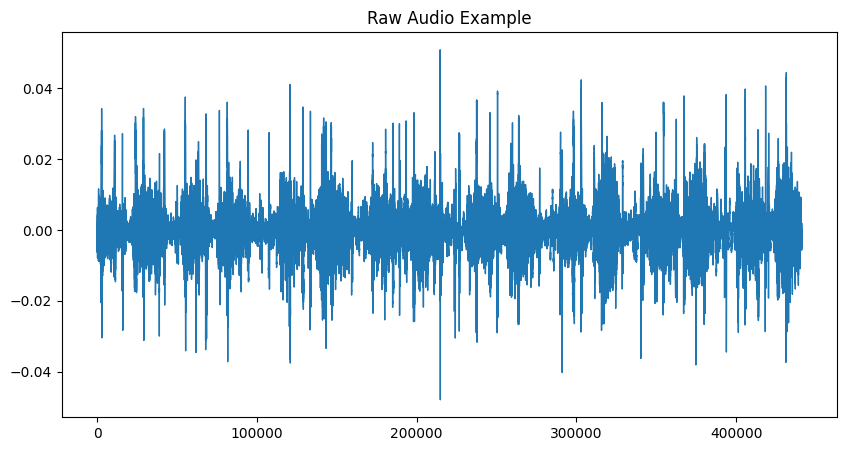

In [14]:
#Surowy przebieg pliku
pd.Series(wave).plot(figsize=(10, 5),
                  lw=1,
                  title='Raw Audio Example')
plt.show()


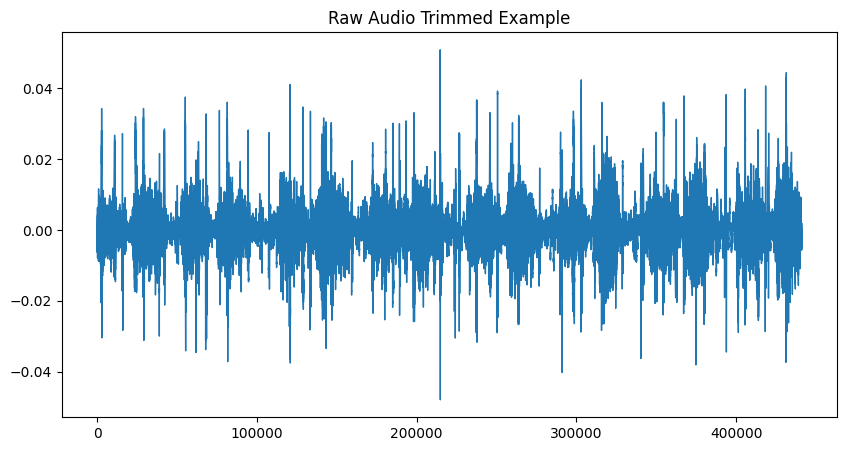

In [15]:
# Korekta ciszy dźwięku w audio
wave_trimmed, _ = librosa.effects.trim(wave, top_db=40)
pd.Series(wave_trimmed).plot(figsize=(10, 5),
                  lw=1,
                  title='Raw Audio Trimmed Example')
plt.show()

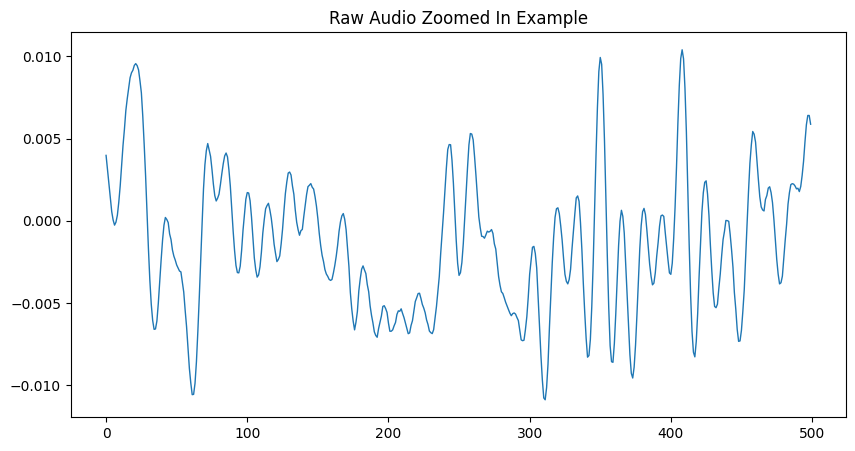

In [16]:
# Przybliżony przebieg dźwięku
pd.Series(wave[30000:30500]).plot(figsize=(10, 5),
                  lw=1,
                  title='Raw Audio Zoomed In Example')
plt.show()

In [17]:
# Tranformata Fouriera
D = librosa.stft(wave)
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
S_db.shape


(1025, 862)

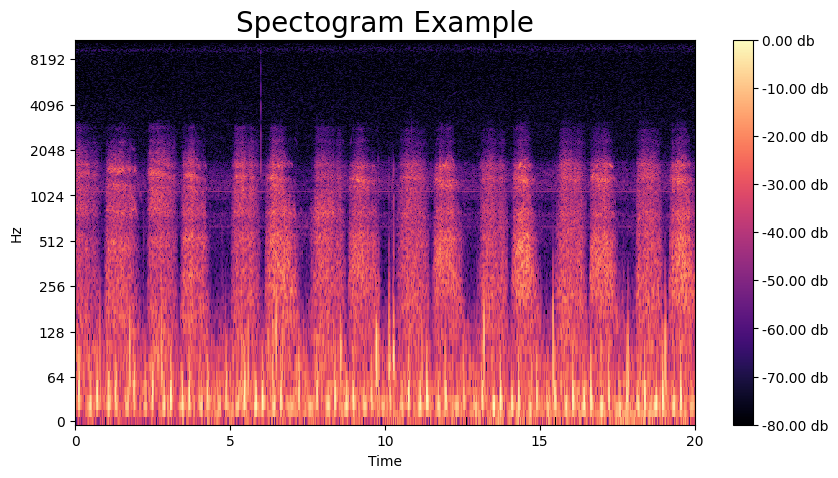

In [18]:
# Spektogram z dźwięku
fig, ax = plt.subplots(figsize=(10, 5))
img = librosa.display.specshow(S_db,
                              x_axis='time',
                              y_axis='log',
                              ax=ax)
ax.set_title('Spectogram Example', fontsize=20)
fig.colorbar(img, ax=ax, format=f'%0.2f db')
plt.show()

In [19]:
# Tworzenie spektogramu mel
mel_spec = librosa.feature.melspectrogram(y=wave,
                                   sr=sr,
                                   n_mels=128 * 2,)
S_db_mel = librosa.amplitude_to_db(mel_spec, ref=np.max)

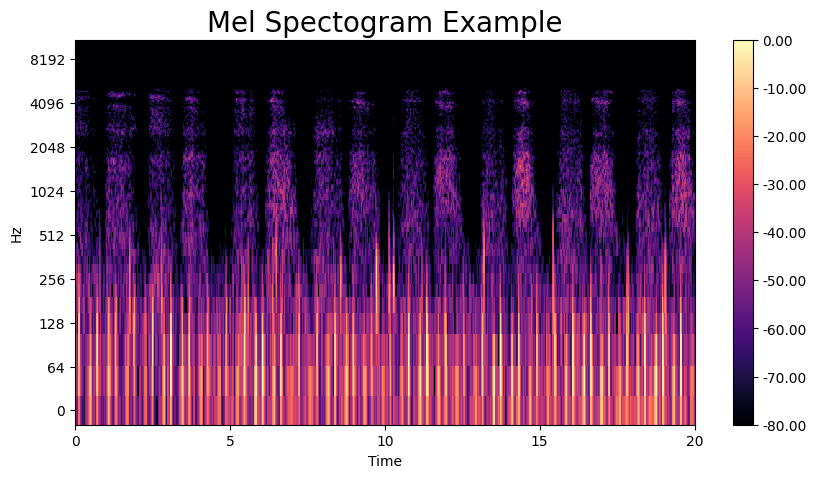

In [20]:
fig, ax = plt.subplots(figsize=(10, 5))
# Spektogram mel
img = librosa.display.specshow(S_db_mel,
                              x_axis='time',
                              y_axis='log',
                              ax=ax)
ax.set_title('Mel Spectogram Example', fontsize=20)
fig.colorbar(img, ax=ax, format=f'%0.2f')
plt.show()

## Tworzenie dataset'u

In [21]:
SAMPLE_RATE = 32000
CHUNK_LENGTH = 3

In [27]:
def get_spectogram(filepath,sample_rate=16000,image_shape=(224,224)):
    wave, rate = librosa.load(path = filepath, sr = sample_rate)
    mel_spectogram = librosa.feature.melspectrogram(y = wave,
                                                    sr = rate,
                                                    n_fft = 1024,
                                                    hop_length = 512,
                                                    n_mels = image_shape[0] * 2)
    
    mel_spectogram = librosa.amplitude_to_db(mel_spectogram, ref = np.max)
    #Normalizacja
    mel_spectogram -= mel_spectogram.min()
    mel_spectogram /= mel_spectogram.max()

    return np.array(mel_spectogram)

In [28]:
def prepare_spectograms():

    class_names = os.listdir('./data/audio')
    print(f"Nazwy klas: {class_names}")

    for class_name in class_names:
        files_disease = os.listdir(f'./data/audio/{class_name}')

        for file in files_disease:
            print(f"{class_name} - > {file}")

            spectogram = get_spectogram(f'./data/audio/{class_name}/{file}', sample_rate = SAMPLE_RATE)

            file_name = file[:-4]
            #print(file_name)

            #Zapis spektogramu
            saved_path = os.path.join(f'./data/spectograms/{class_name}/{file_name}.png')
            print(saved_path)

            image = Image.fromarray(spectogram * 255).convert("L")
            image.save(saved_path)

    print("SPEKTOGRAMY ZOSTAŁY PRZYGOTOWANE...")

    

e:\Anaconda\envs\detect\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


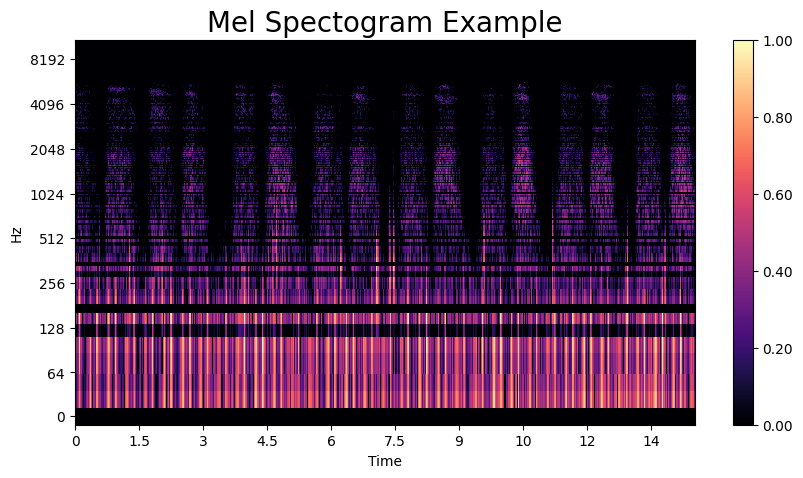

In [29]:
test = get_spectogram('./data/audio/Bronchiectasis/111_1b2_Tc_sc_Meditron.wav')

fig, ax = plt.subplots(figsize=(10, 5))
# Spektogram mel
img = librosa.display.specshow(test,
                              x_axis='time',
                              y_axis='log',
                              ax=ax)
ax.set_title('Mel Spectogram Example', fontsize=20)
fig.colorbar(img, ax=ax, format=f'%0.2f')
plt.show()

# Przygotowanie spektogramów z plików audio

In [30]:
prepare_spectograms()

Nazwy klas: ['Asthma', 'Bronchiectasis', 'Bronchiolitis', 'COPD', 'Healthy', 'LRTI', 'Pneumonia', 'URTI']
Asthma - > 103_2b2_Ar_mc_LittC2SE.wav
./data/spectograms/Asthma/103_2b2_Ar_mc_LittC2SE.png
Bronchiectasis - > 111_1b2_Tc_sc_Meditron.wav
./data/spectograms/Bronchiectasis/111_1b2_Tc_sc_Meditron.png
Bronchiectasis - > 111_1b3_Tc_sc_Meditron.wav
./data/spectograms/Bronchiectasis/111_1b3_Tc_sc_Meditron.png
Bronchiectasis - > 116_1b2_Pl_sc_Meditron.wav
./data/spectograms/Bronchiectasis/116_1b2_Pl_sc_Meditron.png
Bronchiectasis - > 116_1b2_Tc_sc_Meditron.wav
./data/spectograms/Bronchiectasis/116_1b2_Tc_sc_Meditron.png
Bronchiectasis - > 168_1b1_Al_sc_Meditron.wav
./data/spectograms/Bronchiectasis/168_1b1_Al_sc_Meditron.png
Bronchiectasis - > 169_1b1_Lr_sc_Meditron.wav
./data/spectograms/Bronchiectasis/169_1b1_Lr_sc_Meditron.png
Bronchiectasis - > 169_1b2_Ll_sc_Meditron.wav
./data/spectograms/Bronchiectasis/169_1b2_Ll_sc_Meditron.png
Bronchiectasis - > 196_1b1_Pr_sc_Meditron.wav
./data/s

 ## Przygotowanie danych ze zbioru Virufy-data